In [1]:
%load_ext autoreload
%autoreload 2

# Analyzing RR Lyrae stars for the Blazhko effect

In this notebook we are analyzing the data calculated in nb 03 in order to look into possible Blazhko stars.

In [2]:
# IMPORTING LIBRARIES
# --------------------

# AstroML & Astropy
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit

# ZTF
from ztfquery import lightcurve

# Basic libraries
import random
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd
import dask.dataframe as dd 

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm
from scipy.signal import find_peaks
from array import array

In [3]:
# CONFIG
sns.set_theme() # setting the theme for plotting
np.random.seed(42)

colors = ['#1A090D', '#D8C99B', '#D8973C', '#BD632F', '#273E47']
cmap = mcolors.ListedColormap(colors)

font = FontProperties()
font.set_family('avenir')
font.set_name('Avenir')
font.set_style('normal')
font.set_size('xx-large')

%matplotlib inline  

In [4]:
# Importing custom libraries
# ----------------------------
sys.path.insert(0,'../src/')
from config import*
from descriptive_stats import *
from plots import *

from selection import *
from lc_analysis import *

Loading the data!


In [5]:
# DATA
data = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library

## Loading the data

In [6]:
lightcurve_analysis = pd.read_csv('../outputs/LC_ANALYSIS_FINAL.csv')

In [7]:
lightcurve_analysis.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPztf_chi2dofR,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit
0,29848,0.557021,0.557037,0.557029,1.000028,301.0,0.178198,3.028026,1.451336,0.185326,...,3.645075,0.052598,16.195588,3.955532,15.756993,0.925157,0,0.25,0.0,0.25
1,50402,0.643301,0.643296,0.643298,0.999992,284.0,0.107683,0.595738,0.733869,0.106092,...,1.162370,0.031558,2.097207,1.177316,16.088901,0.486372,0,0.25,0.0,0.25
2,62892,0.530776,0.530785,0.530781,1.000017,276.0,0.108544,1.058829,0.934727,0.114002,...,3.137436,0.069562,19.794606,3.288505,15.961735,0.641651,1,0.25,0.0,0.25
3,91437,0.674732,0.674738,0.674735,1.000009,177.0,0.040798,2.775415,1.352923,0.040888,...,1.556614,0.020152,4.243845,1.580792,15.002323,0.864724,0,0.25,0.0,0.25
4,95250,0.313870,0.313876,0.313873,1.000019,222.0,0.162040,0.816590,0.859616,0.165801,...,1.341415,0.054686,3.709448,1.515406,16.680144,0.461509,1,0.25,0.0,0.25


In [8]:
periodograms = pickle.load(open("../outputs/periodograms_final.pkl", "rb"))

In [9]:
FITS = np.load('../outputs/fits_whole.npy', allow_pickle=True)

# Analysis

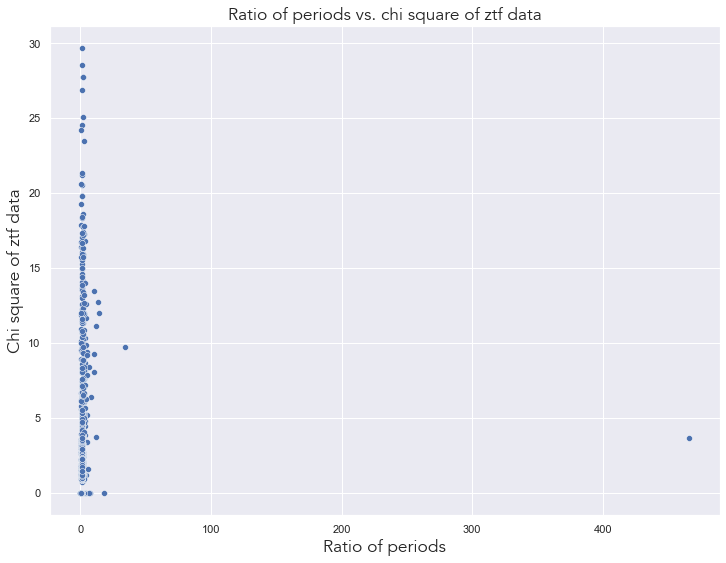

In [10]:
plt.figure(figsize=(12,9))
sns.scatterplot(lightcurve_analysis, x='Pratio', y='ZPztf_chi2dofR')
plt.title('Ratio of periods vs. chi square of ztf data', fontproperties=font)
plt.xlabel('Ratio of periods', fontproperties=font)
plt.ylabel('Chi square of ztf data', fontproperties=font)
plt.show()

In [11]:
pratio_lc = lightcurve_analysis.head(20)
pratio_lc.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,LPlin_rmsdmag,LPlin_chi2dof,LPlin_chi2dofR,LPmean_rmsdmag,...,ZPztf_chi2dofR,ZPmean_rmsdmag,ZPmean_chi2dof,ZPmean_chi2dofR,Zmmax,Zampl,Lindicator,Llimit,Zindicator,Zlimit
0,29848,0.557021,0.557037,0.557029,1.000028,301.0,0.178198,3.028026,1.451336,0.185326,...,3.645075,0.052598,16.195588,3.955532,15.756993,0.925157,0,0.25,0.0,0.25
1,50402,0.643301,0.643296,0.643298,0.999992,284.0,0.107683,0.595738,0.733869,0.106092,...,1.162370,0.031558,2.097207,1.177316,16.088901,0.486372,0,0.25,0.0,0.25
2,62892,0.530776,0.530785,0.530781,1.000017,276.0,0.108544,1.058829,0.934727,0.114002,...,3.137436,0.069562,19.794606,3.288505,15.961735,0.641651,1,0.25,0.0,0.25
3,91437,0.674732,0.674738,0.674735,1.000009,177.0,0.040798,2.775415,1.352923,0.040888,...,1.556614,0.020152,4.243845,1.580792,15.002323,0.864724,0,0.25,0.0,0.25
4,95250,0.313870,0.313876,0.313873,1.000019,222.0,0.162040,0.816590,0.859616,0.165801,...,1.341415,0.054686,3.709448,1.515406,16.680144,0.461509,1,0.25,0.0,0.25


LINEAR ID:1273940
-------------------------


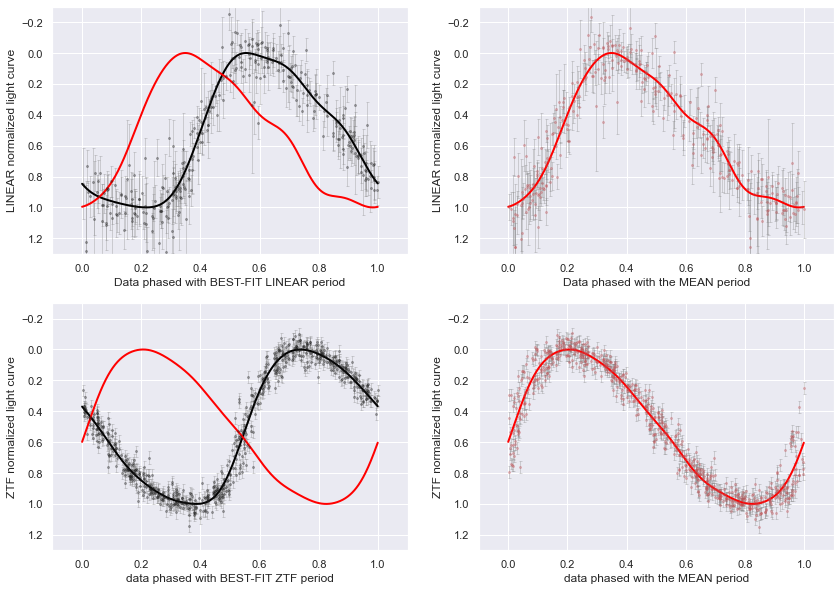

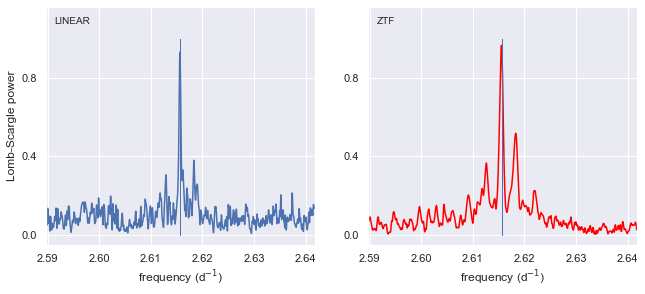

-------------------------
LINEAR ID:1551619
-------------------------


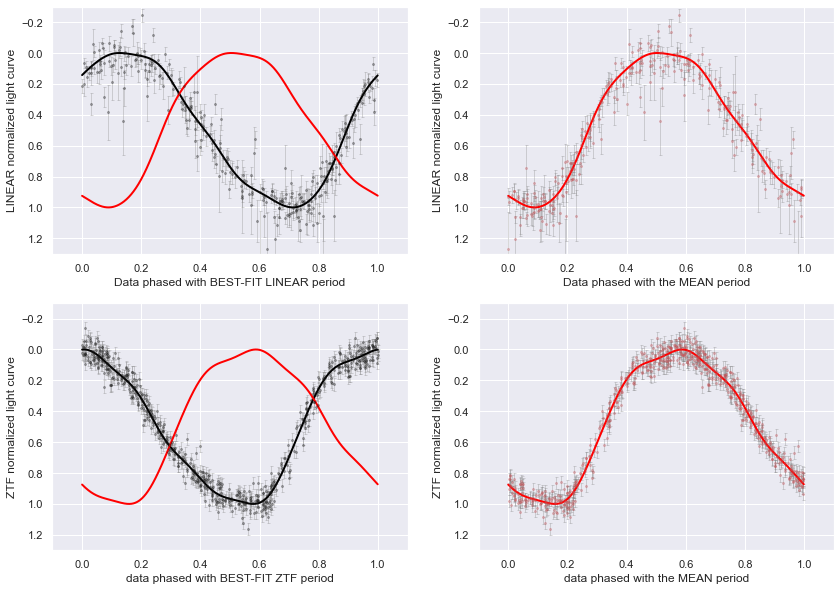

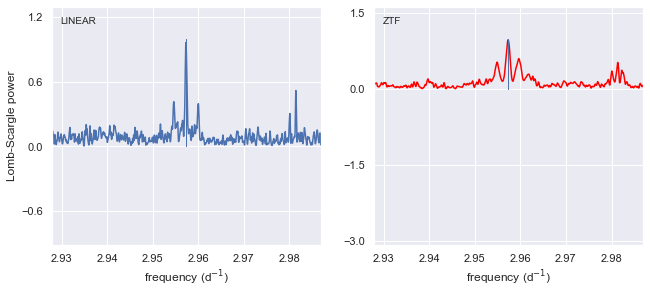

-------------------------
LINEAR ID:2280940
-------------------------


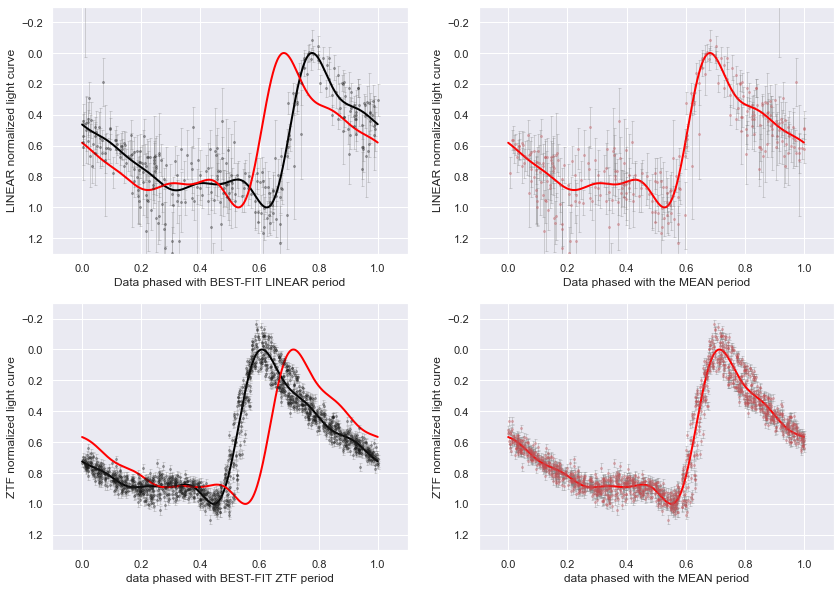

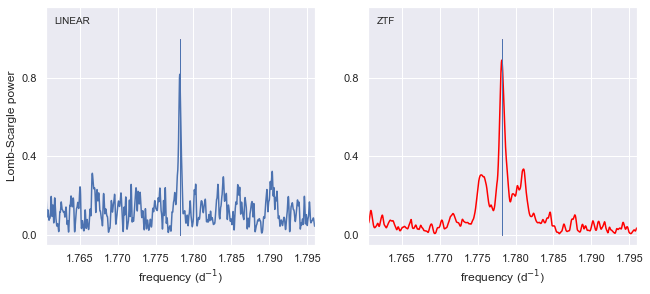

-------------------------
LINEAR ID:2584911
-------------------------


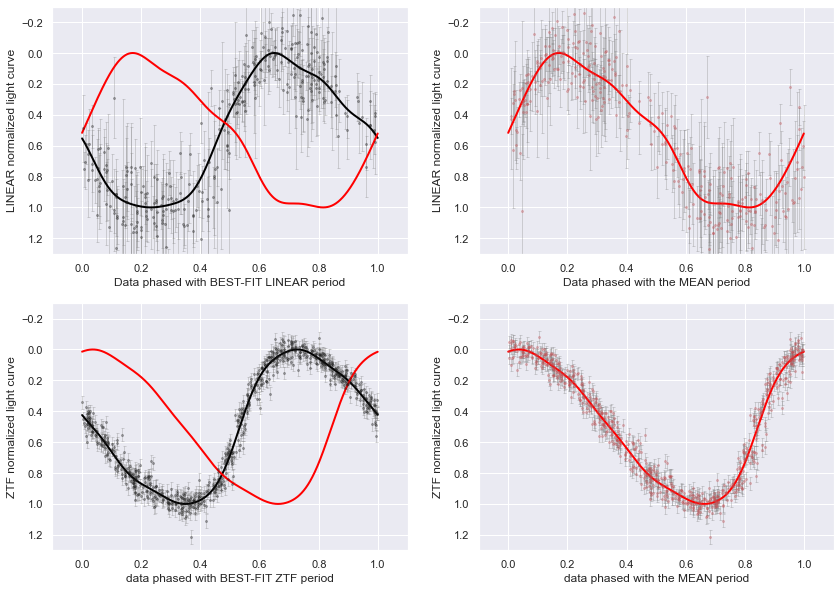

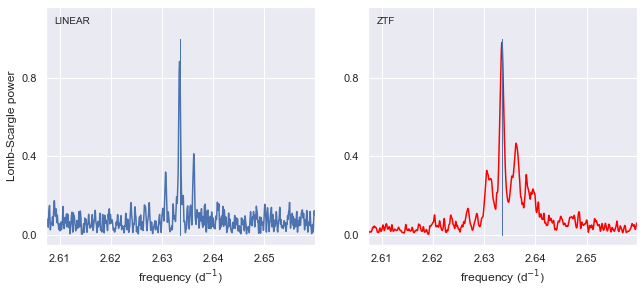

-------------------------
LINEAR ID:2672050
-------------------------


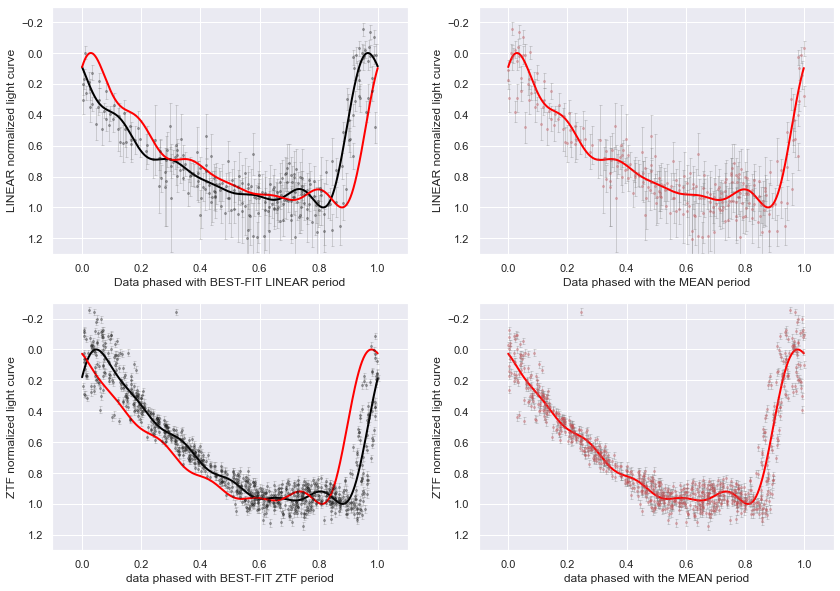

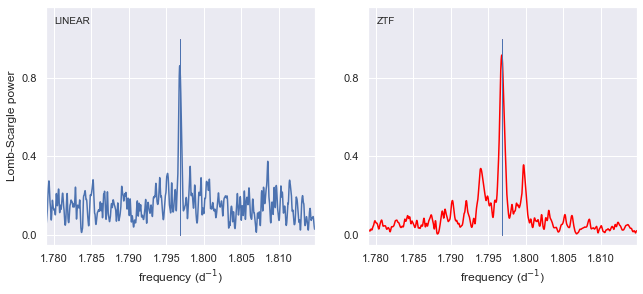

-------------------------
LINEAR ID:2839032
-------------------------


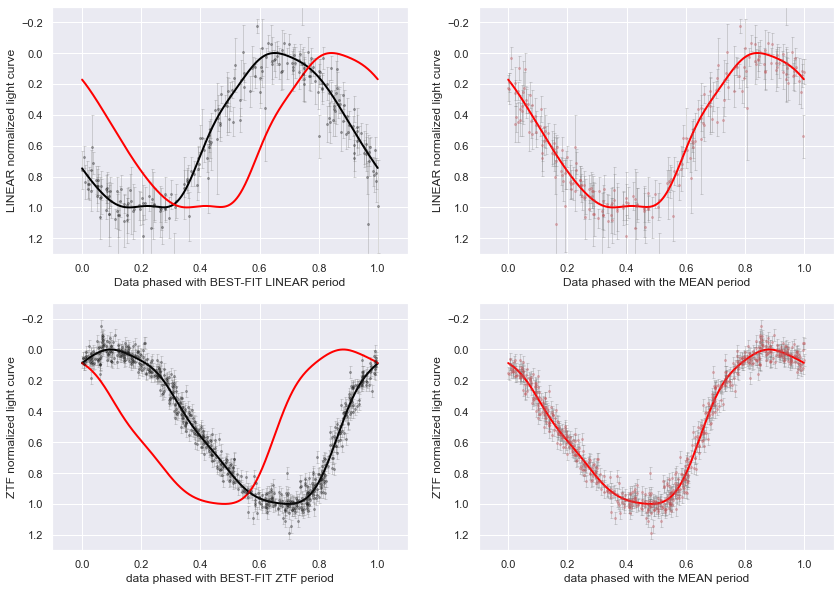

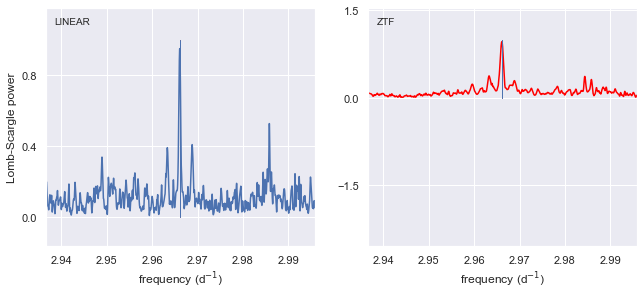

-------------------------
LINEAR ID:2913030
-------------------------


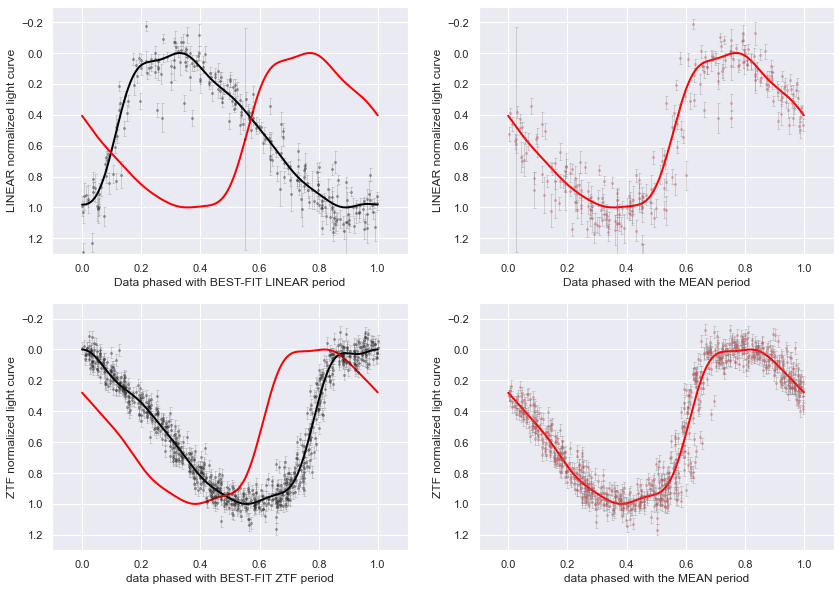

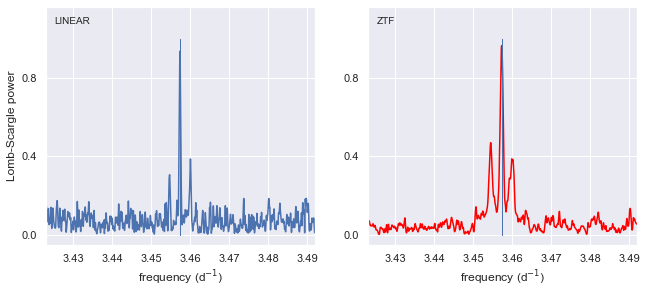

-------------------------
LINEAR ID:2936953
-------------------------


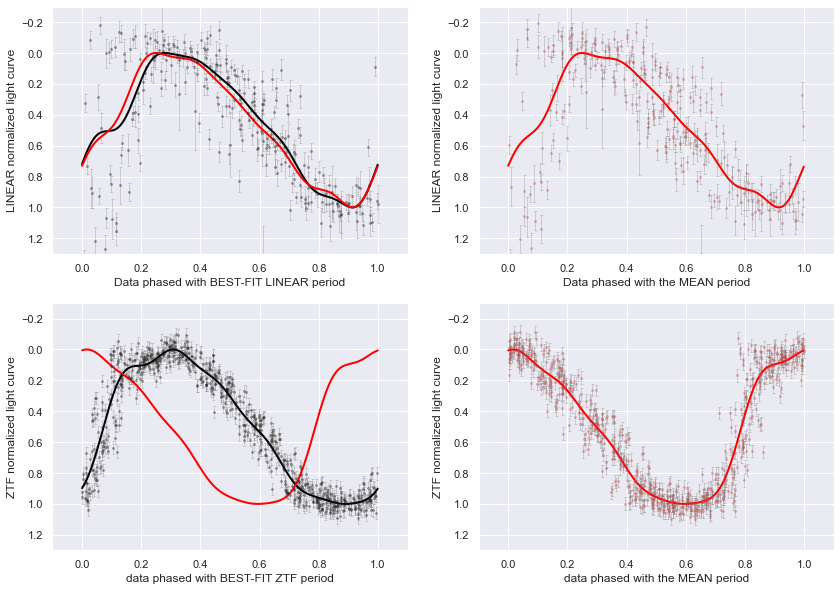

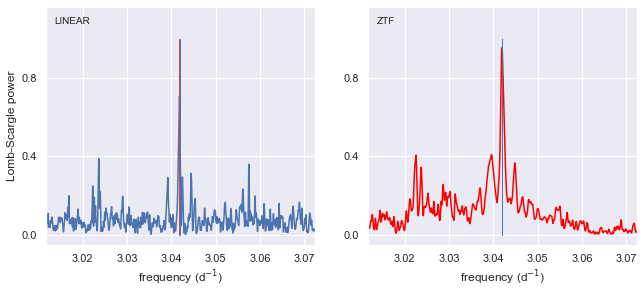

-------------------------
LINEAR ID:3140139
-------------------------


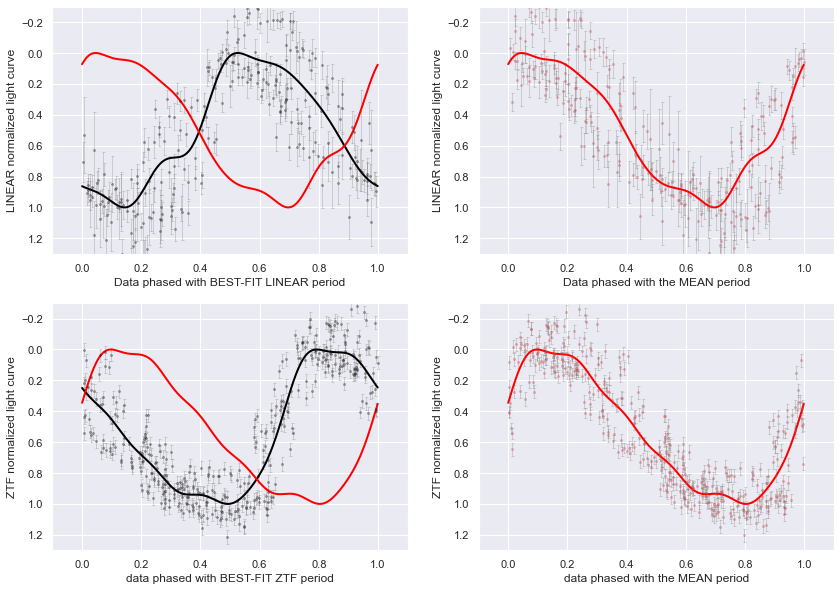

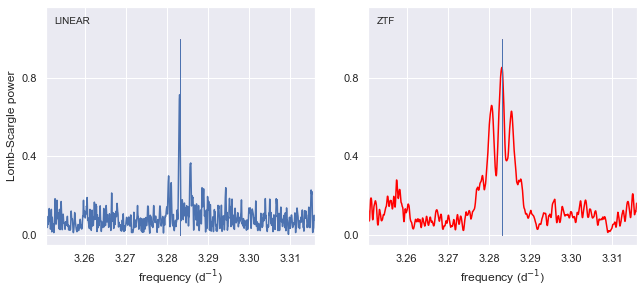

-------------------------
LINEAR ID:3356801
-------------------------


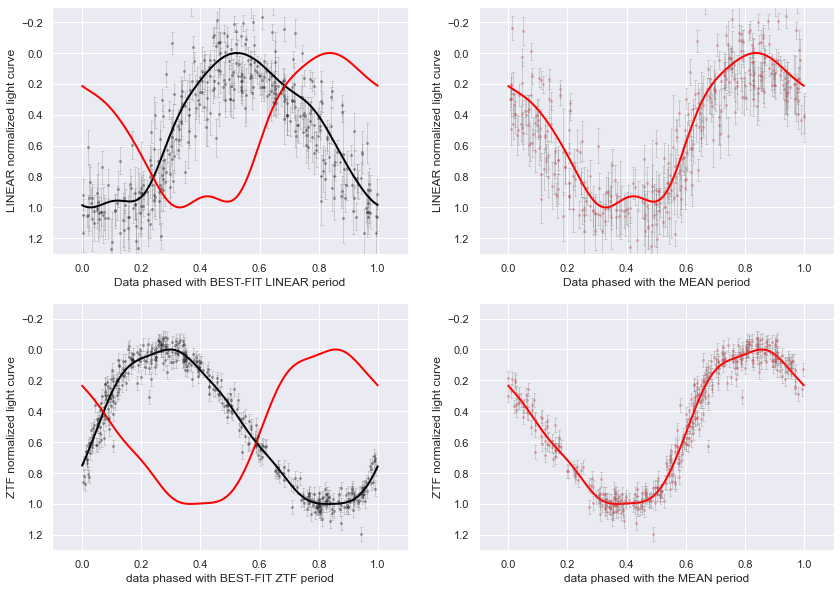

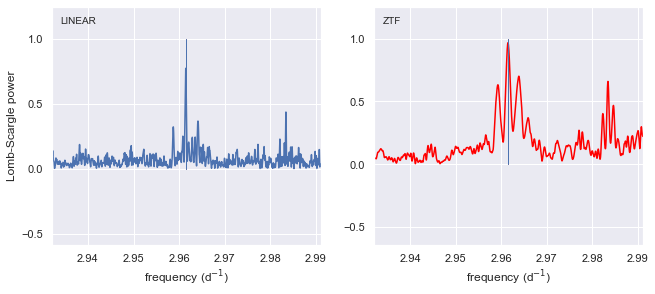

-------------------------


In [21]:
lc_dataset = make_blazhko_analysis_dataset(lightcurve_analysis, lindicator=1, zindicator=1)

test = 10
for i in range(test):
    LID = lc_dataset['LINEAR id'].to_numpy()[i]
    print(f'LINEAR ID:{LID}')
    print('-'*25)
    blazhko_analysis(lc_dataset, Lid=LID, order=i, PD=periodograms, fits=FITS)
    print('-'*25)